# Exploratory Data Analysis Source Data

---

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Exploratory-Data-Analysis-Source-Data" data-toc-modified-id="Exploratory-Data-Analysis-Source-Data-1">Exploratory Data Analysis Source Data</a></span><ul class="toc-item"><li><span><a href="#US-Energy-Information-Administration-(EIA)-Drilling-Productivity-Report" data-toc-modified-id="US-Energy-Information-Administration-(EIA)-Drilling-Productivity-Report-1.1">US Energy Information Administration (EIA) Drilling Productivity Report</a></span></li><li><span><a href="#Nightfire-data" data-toc-modified-id="Nightfire-data-1.2">Nightfire data</a></span></li><li><span><a href="#US-Census-Counties" data-toc-modified-id="US-Census-Counties-1.3">US Census Counties</a></span></li></ul></li></ul></div>

In [23]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [102]:
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

In [88]:
from capstone.etl.eia_retrieval import eia_retrieval
from capstone.etl.eia_parse import eia_parse_county, eia_parse_data
from tools.tools import get_current_time, read_json

In [89]:
plt.style.use('ggplot')

In [14]:
config = read_json('../config.json')

current_date = get_current_time('yyyymmdd')

wd = f"{config['workspace_directory']}/data"

## US Energy Information Administration (EIA) Drilling Productivity Report


In [16]:
eia_xls = eia_retrieval(f"{wd}/input/eia")
eia_cnty = eia_parse_county(eia_xls)
eia_data = eia_parse_data(eia_xls)  # parse the target variable(s) data

 parse eia data
    for Anadarko Region
    for Appalachia Region
    for Bakken Region
    for Eagle Ford Region
    for Haynesville Region
    for Niobrara Region
    for Permian Region


In [44]:
eia_data.head(3)

,month,natgas_mcf_d_legacy_production_change,natgas_mcf_d_production_per_rig,natgas_mcf_d_total_production,oil_bbl_d_legacy_production_change,oil_bbl_d_production_per_rig,oil_bbl_d_total_production,region,rig_count
0,2007-01-01,-112112.15,840.713208,4031234.67,-370.40457,19.309806,126398.038,Anadarko Region,176.0
1,2007-02-01,-115386.99,847.042307,4053324.71,-723.02653,20.184060,134177.221,Anadarko Region,180.0
2,2007-03-01,-118312.94,851.808491,4165395.70,-1036.83450,20.970401,137515.513,Anadarko Region,166.0


In [146]:
eia_data.dtypes

month                                    datetime64[ns]
natgas_mcf_d_legacy_production_change           float64
natgas_mcf_d_production_per_rig                 float64
natgas_mcf_d_total_production                   float64
oil_bbl_d_legacy_production_change              float64
oil_bbl_d_production_per_rig                    float64
oil_bbl_d_total_production                      float64
region                                           object
rig_count                                       float64
dtype: object

In [147]:
eia_data.describe()

,natgas_mcf_d_legacy_production_change,natgas_mcf_d_production_per_rig,natgas_mcf_d_total_production,oil_bbl_d_legacy_production_change,oil_bbl_d_production_per_rig,oil_bbl_d_total_production,rig_count
count,1113.000000,1113.000000,1.113000e+03,1113.000000,1113.000000,1.113000e+03,1099.000000
mean,-212149.221062,3015.019143,6.228038e+06,-34171.863542,333.005350,6.011631e+05,140.606915
std,190971.732878,3750.247774,5.757697e+06,47924.001884,416.978172,7.742754e+05,115.153229
min,-997642.260000,77.526847,1.861918e+05,-288983.150000,2.988818,2.400000e+04,16.000000
25%,-292438.000000,954.016977,3.645695e+06,-48592.199000,33.047552,6.500000e+04,56.000000
50%,-152354.960000,1472.449060,4.771623e+06,-14363.063000,131.034944,2.781470e+05,99.000000
75%,-95728.486000,4022.562710,6.790772e+06,-2011.937500,459.616311,9.310919e+05,189.500000
max,-1787.853800,18828.672900,3.384569e+07,-280.865740,1904.260130,4.854688e+06,565.000000


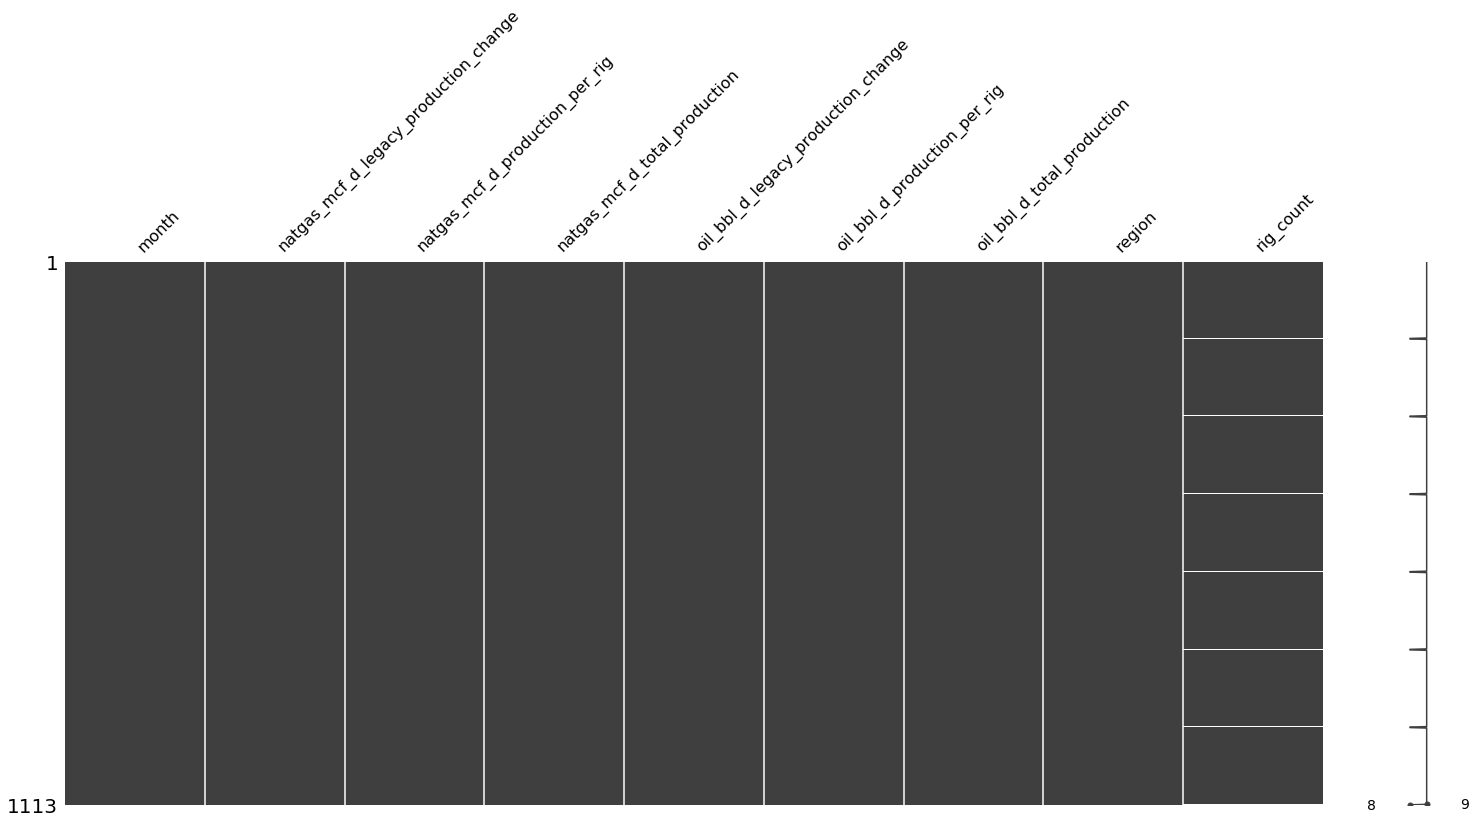

In [26]:
msno.matrix(eia_data);  # check for missing data

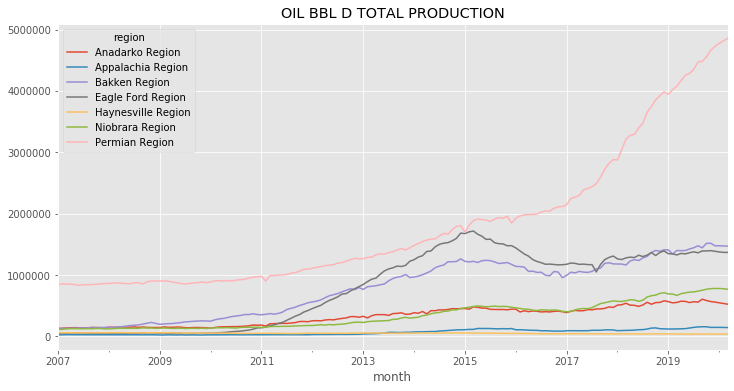

In [90]:
var = 'oil_bbl_d_total_production'
eia_data.pivot(index="month", columns="region", values=var).plot(
    figsize=(12, 6), 
    title=var.replace('_', ' ').upper(),
);

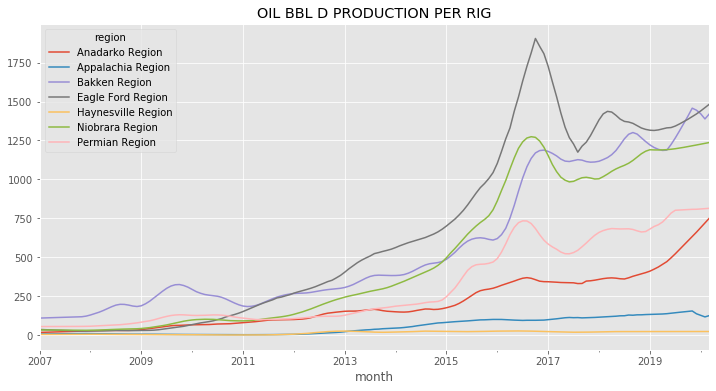

In [91]:
var = 'oil_bbl_d_production_per_rig'
eia_data.pivot(index="month", columns="region", values=var).plot(
    figsize=(12, 6), 
    title=var.replace('_', ' ').upper(),
);

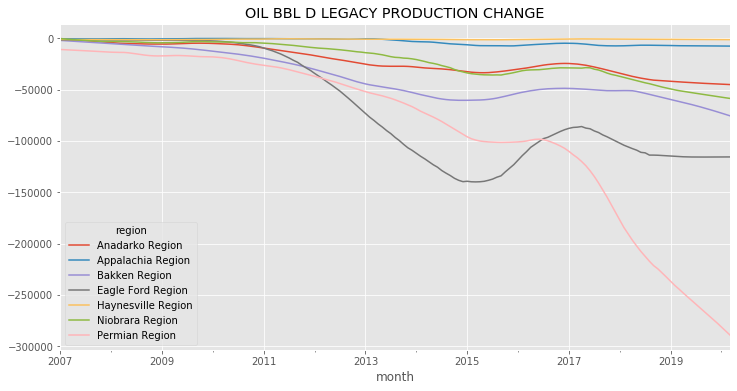

In [92]:
var = 'oil_bbl_d_legacy_production_change'
eia_data.pivot(index="month", columns="region", values=var).plot(
    figsize=(12, 6), 
    title=var.replace('_', ' ').upper(),
);

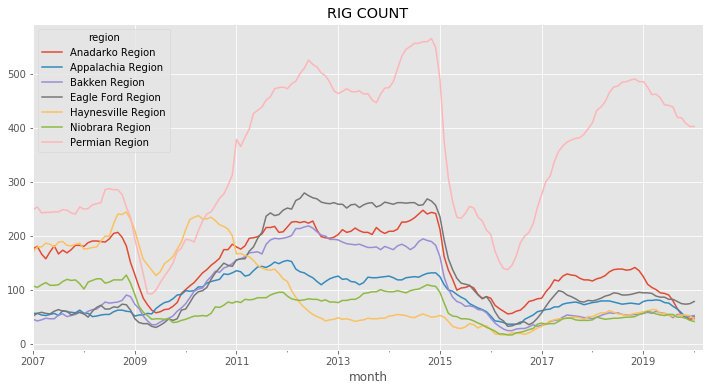

In [93]:
var = 'rig_count'
eia_data.pivot(index="month", columns="region", values=var).plot(
    figsize=(12, 6), 
    title=var.replace('_', ' ').upper(),
);

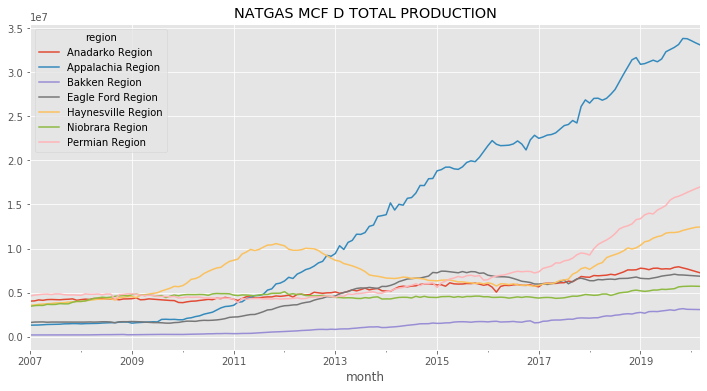

In [94]:
var = 'natgas_mcf_d_total_production'
eia_data.pivot(index="month", columns="region", values=var).plot(
    figsize=(12, 6), 
    title=var.replace('_', ' ').upper(),
);

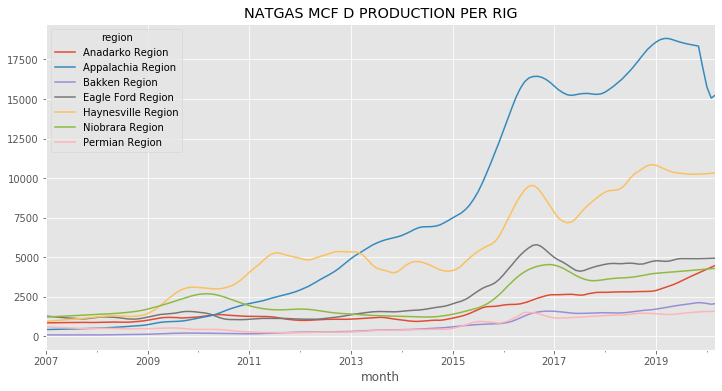

In [95]:
var = 'natgas_mcf_d_production_per_rig'
eia_data.pivot(index="month", columns="region", values=var).plot(
    figsize=(12, 6), 
    title=var.replace('_', ' ').upper(),
);

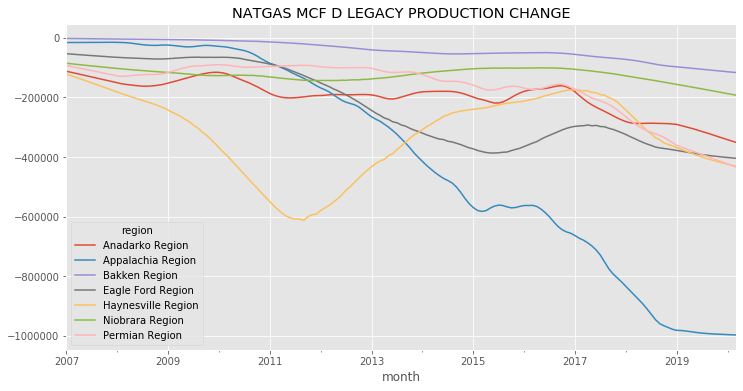

In [96]:
var = 'natgas_mcf_d_legacy_production_change'
eia_data.pivot(index="month", columns="region", values=var).plot(
    figsize=(12, 6), 
    title=var.replace('_', ' ').upper(),
);

## Nightfire data


## US Census Counties

In [166]:
census = gpd.read_file('../data/input/census/tl_2017_us_county.shp')

census.columns = [c.lower() for c in census.columns]

census = census[
    (census['statefp'] != '66') & (census['statefp'] != '78') & (census['statefp'] != '69') & (census['statefp'] != '60') & (census['statefp'] != '02') & (census['statefp'] != '15') & (census['statefp'] != '72')
]  # drop alaska and hawaii and island territories 

census = census.to_crs(epsg=5070)  # NAD83 / Conus Albers

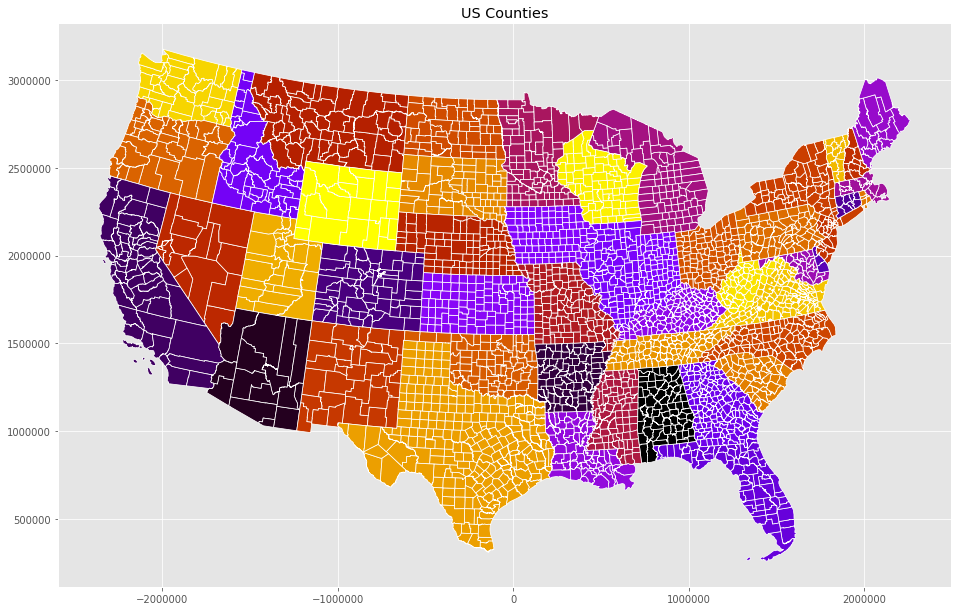

In [174]:
census.plot(figsize=(16, 16), column='statefp', cmap='gnuplot', edgecolor='white', linewidth=0.75)
plt.title('US Counties');